In [49]:
"""Simple scaled-down Transformer model implementation"""

from re import sub
import numpy as np
import pandas as pd 

import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from transformers import GPT2Model, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn.functional import one_hot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from matplotlib.pyplot import plot, legend, show, xlabel, ylabel, title

In [50]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [51]:
# Define the training dataset and dataloader
class PhoneticDataset(torch.utils.data.Dataset):
    def __init__(self, phonetic_features, labels):
        self.phonetic_features = phonetic_features
        self.labels = labels

    def __len__(self):
        return len(self.phonetic_features)

    def __getitem__(self, idx):
        return {
            'phonetic_features': torch.tensor(self.phonetic_features[idx], dtype=torch.int32),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [52]:
"""Read features.txt and initialize feature dictionaries. Adapated from Brandon's LSTM code."""

def get_strings(data_file):
  """Process input file into a list of strings."""
  input_file = open(data_file)
  input_file.readline() # Skip first line
  UR_strings, SR_strings, syll_lengths = [], [], []
  ur_num = 0

  for line in input_file.readlines():
    columns = line.rstrip().split(",")
    if len(columns) == 2:
      ur, sr = columns
      if sr == "" or ur == "":
        continue
      ur_num += 1

      syll_lengths.append(len([seg for seg in ur.split(" ") if seg != ""]))
      UR_strings.append(ur)
      SR_strings.append(sr[-5:]) # Last 5 characters correspond to plural suffix
    else:
       print(line)
       raise Exception("Training data error! All lines should have 2 columns in TD files!")
  input_file.close()

  return UR_strings, SR_strings, syll_lengths

def get_data(UR_strings, SR_strings, syll_lengths, symbol2idx, suffix2label, override_max_syll=0):
  """
  UR_strings[:2] = ['IY0 G UW1 CH', 'L OW1 K']
  SR_strings[:2] = ['W AH0', 'L EY0']
  syll_lengths[:2] = [4, 3]
   
  """
  if override_max_syll:
    assert override_max_syll > max(syll_lengths)
    max_len = override_max_syll
  else: 
    max_len = max(syll_lengths)
  
  X_list = []
  Y_list = []
  padding_strs = []
  for word_index, syll_length in enumerate(syll_lengths):
    padding = " ".join(["_"]*(max_len-syll_length))
    this_ur = UR_strings[word_index]+" "+padding # Singular form + padding as string
    padding_strs.append(this_ur)
    this_sr = SR_strings[word_index][-5:] # Suffix as string

    #Fix some errors in data files:
    this_ur = sub(" J ", " Y ", this_ur)
    this_ur = sub(" C ", " CH ", this_ur)

    X_list.append([symbol2idx[seg] for seg in this_ur.split(" ") if seg != ""])
    Y_list.append(suffix2label[this_sr])

  X = np.array(X_list)
  Y = np.array(Y_list)

  return X, Y


In [53]:
FEATURES_FILE = "feats.txt"
TRAINING_DATA = "./EqualDefault/equalFreq_train.txt"

# Create phonetic features embedding matrix
feat_file = open(FEATURES_FILE, "r")
feat_names = feat_file.readline().rstrip().split("\t")[1:] # Skip first space
symbol2feats = {'_': [0.0 for f in feat_names]}

symbol2idx = {}
curr_idx = 0

for line in feat_file.readlines():
  columns = line.rstrip().split("\t")
  seg = columns[0]
  values = [{"-":-1.0, "+":1.0, "0":0.0}[v] for v in columns[1:]]
  symbol2feats[seg] = values
  symbol2idx[seg] = curr_idx
  curr_idx += 1

symbol2idx["_"] = curr_idx
idx2symbol = {idx:symbol for symbol, idx in symbol2idx.items()}

# Create embedding matrix
embedding_matrix = [symbol2feats[idx2symbol[i]] for i in range(len(idx2symbol))]

#outputs
suffix2label = {
	"Y IY0": 0, #yee
	"W AH0": 1, #wuh
	"L EY0": 2 #lay
	}

URs, SRs, Ls = get_strings(TRAINING_DATA)
X, y = get_data(URs, SRs, Ls, symbol2idx, suffix2label)

# Split the dataset into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train).to(device)
y_train_one_hot = one_hot(torch.tensor(y_train).to(torch.int64), num_classes=3).to(torch.float32).to(device)

# Assuming phonetic_features and labels are available as lists or numpy arrays
dataset = PhoneticDataset(X_train, y_train_one_hot)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


In [55]:
# Modify the input layer to accept phonetic feature vectors
class GPT2WithPhoneticFeatures(torch.nn.Module):
	def __init__(self, gpt2_model, feature_embeddings):
		super(GPT2WithPhoneticFeatures, self).__init__()
		self.gpt2_model = gpt2_model
		num_features, embedding_dim = feature_embeddings.shape # (43, 19)
		self.phonetic_embedding = nn.Embedding.from_pretrained(feature_embeddings, freeze=True)
		
		assert embedding_dim == config.n_embd
		
		self.relu = nn.ReLU()
		self.classifier = nn.Linear(config.n_embd, 3)

	def forward(self, phonetic_inputs):
		embd_inputs = self.phonetic_embedding(phonetic_inputs)
		outputs = self.gpt2_model(inputs_embeds=embd_inputs)
		relued = self.relu(outputs.last_hidden_state)
		logits = self.classifier(relued)
		return logits

# Define the configuration
config = GPT2Config(
	vocab_size=43, 
	n_positions=5,
	n_ctx=5,
	n_embd=19,
	n_layer=2,
	n_head=1
)

# Load the pre-trained GPT model
model = GPT2Model(config)

epochs = 1000
# Initialize embedding matrix
embeddings = torch.tensor(embedding_matrix, dtype=torch.float32).to(device) # Shape (43, 19)

# Initialize the modified GPT-2 model
modified_gpt2 = GPT2WithPhoneticFeatures(model, embeddings).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {pytorch_total_params}")

# Define the optimizer and scheduler
optimizer = AdamW(modified_gpt2.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()
total_steps = len(dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
allLosses = []
modified_gpt2.train()
for epoch in range(epochs):
	for batch in dataloader:
		phonetic_features = batch['phonetic_features']

		labels = batch['labels']

		optimizer.zero_grad()

		outputs = modified_gpt2(phonetic_features)
		loss = criterion(outputs, labels)
		loss.backward()

		optimizer.step()
		scheduler.step()
	
	if (epoch+1) % 50 == 0:
		print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
		allLosses.append(loss.item())

# Save the trained model
# torch.save(modified_gpt2.state_dict(), 'modified_gpt2_with_phonetic_features.pt')


Trainable parameters: 10108


/tmp/ipykernel_385326/74298541.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'phonetic_features': torch.tensor(self.phonetic_features[idx], dtype=torch.int32),
/tmp/ipykernel_385326/74298541.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.labels[idx], dtype=torch.long)


Epoch 50, Loss: 0.7043711543083191
Epoch 100, Loss: 0.6622956395149231
Epoch 150, Loss: 0.6491360664367676
Epoch 200, Loss: 0.6659570336341858
Epoch 250, Loss: 0.6279313564300537
Epoch 300, Loss: 0.6379976868629456


KeyboardInterrupt: 

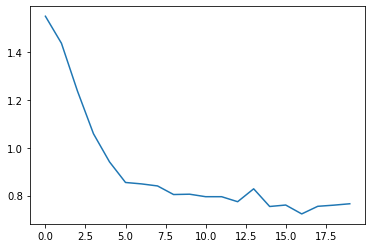

In [ ]:
#Plot average loss (for checking lr, etc.)
from matplotlib import pyplot as plt
plt.plot(allLosses)

In [ ]:
X_valid = torch.tensor(X_train, dtype=torch.int32)

# Inference and accuracy measurement
modified_gpt2.eval()
with torch.no_grad():
	test_outputs = modified_gpt2(X_valid)
	test_outputs_last_layer = test_outputs[:, -1, :]
	predicted_classes = torch.argmax(test_outputs_last_layer, dim=-1)

class_report = classification_report(y_train, predicted_classes)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       328
           1       0.00      0.00      0.00       308
           2       0.33      1.00      0.50       314

    accuracy                           0.33       950
   macro avg       0.11      0.33      0.17       950
weighted avg       0.11      0.33      0.16       950



/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
